# Insurance Modeling Project
This notebook performs insurance data modeling, including handling missing data, feature engineering, and model evaluation.

In [11]:
# Import necessary libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import shap

class InsuranceModeling:
    def __init__(self, df):
        """
        Initialize the class with a DataFrame containing insurance data.
        
        Parameters:
        df (pd.DataFrame): Input DataFrame containing all relevant insurance data.
        """
        self.df = df
        self.model = None

    # Step 1: Data Preparation
    def prepare_data(self):
        """
        Prepare the data by handling missing values, dropping irrelevant columns,
        and selecting only relevant columns for modeling.
        
        Returns:
        pd.DataFrame: Prepared DataFrame ready for feature engineering.
        """
        # Drop columns with 100% missing values
        self.df = self.df.drop(columns=['NumberOfVehiclesInFleet'], errors='ignore')

        # Fill missing values with median for numerical columns and mode for categorical columns
        for col in self.df.columns:
            if self.df[col].dtype == 'object':
                self.df[col].fillna(self.df[col].mode()[0], inplace=True)
            else:
                self.df[col].fillna(self.df[col].median(), inplace=True)

        # Drop irrelevant columns that aren't useful for modeling
        unnecessary_cols = ['PolicyID', 'UnderwrittenCoverID', 'TransactionMonth']  # Example columns
        self.df = self.df.drop(columns=unnecessary_cols, errors='ignore')

        # Select features relevant to modeling TotalPremium and TotalClaims
        relevant_columns = ['SumInsured', 'CalculatedPremiumPerTerm', 'CapitalOutstanding', 'TotalPremium', 'TotalClaims']
        self.df = self.df[relevant_columns]

        return self.df

    # Step 2: Feature Engineering
    def feature_engineering(self):
        """
        Create new features based on existing data for better model performance.
        
        Returns:
        pd.DataFrame: DataFrame with new engineered features.
        """
        # Create ratio features to better capture relationships between variables
        self.df['PremiumToClaimsRatio'] = self.df['TotalPremium'] / (self.df['TotalClaims'] + 1)  # Add 1 to avoid division by zero
        self.df['OutstandingToInsuredRatio'] = self.df['CapitalOutstanding'] / (self.df['SumInsured'] + 1)

        return self.df

    # Step 3: Encoding Categorical Data
    def encode_categorical_data(self):
        """
        Convert categorical columns to numerical using one-hot encoding.
        
        Returns:
        pd.DataFrame: DataFrame with categorical columns encoded.
        """
        # Identify and encode categorical columns
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        self.df = pd.get_dummies(self.df, columns=categorical_cols, drop_first=True)

        return self.df

    # Step 4: Train-Test Split
    def train_test_splitting(self, target='TotalPremium', test_size=0.2):
        """
        Split the dataset into training and testing sets.
        
        Parameters:
        target (str): The target variable for prediction (default is 'TotalPremium').
        test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
        
        Returns:
        X_train, X_test, y_train, y_test: Training and testing sets for features and target.
        """
        # Separate features (X) and target (y)
        X = self.df.drop(columns=[target])
        y = self.df[target]
        
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        
        return X_train, X_test, y_train, y_test

    # Step 5: Train Models
    def train_linear_regression(self, X_train, y_train):
        """
        Train a Linear Regression model on the training data.
        
        Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        
        Returns:
        LinearRegression: Trained Linear Regression model.
        """
        self.model = LinearRegression()
        self.model.fit(X_train, y_train)
        return self.model

    def train_random_forest(self, X_train, y_train):
        """
        Train a Random Forest Regressor on the training data.
        
        Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        
        Returns:
        RandomForestRegressor: Trained Random Forest model.
        """
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        return self.model

    def train_xgboost(self, X_train, y_train):
        """
        Train an XGBoost Regressor on the training data.
        
        Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        
        Returns:
        XGBRegressor: Trained XGBoost model.
        """
        self.model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        return self.model

    # Step 6: Evaluate Model
    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the performance of the trained model on the test data.
        
        Parameters:
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): True values for the target variable on the test set.
        
        Returns:
        dict: Evaluation metrics including R2 score and Mean Squared Error.
        """
        # Predict using the trained model
        y_pred = self.model.predict(X_test)
        
        # Calculate evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        return {"R2 Score": r2, "MSE": mse}

    # Step 7: SHAP for Feature Importance Analysis
    def explain_model_shap(self, X_train):
        """
        Use SHAP (SHapley Additive exPlanations) to explain feature importance of the trained model.
        
        Parameters:
        X_train (pd.DataFrame): Training features used to train the model.
        
        Raises:
        ValueError: If the model type is not supported for SHAP analysis.
        """
        # Check model type and use the appropriate SHAP explainer
        if isinstance(self.model, (xgb.XGBRegressor, RandomForestRegressor)):
            explainer = shap.TreeExplainer(self.model)
        elif isinstance(self.model, LinearRegression):
            explainer = shap.LinearExplainer(self.model, X_train)
        else:
            raise ValueError(f"Unsupported model type for SHAP: {type(self.model)}")
        
        # Calculate SHAP values and generate summary plot
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train)
        

## Load Dataset

In [12]:
# Main Execution: Complete Modeling Pipeline

# Set working directory to project root
os.chdir(r'c:\users\ermias.tadesse\10x\Claim-And-Risk-Analytics-for-Insurance')

# Load the dataset
df = pd.read_csv('data/Final_Task-1_date.csv', low_memory=False)

# Initialize the InsuranceModeling class
insurance_modeling = InsuranceModeling(df)

# Step 1: Prepare the data

In [13]:
# Step 1: Prepare the data
insurance_modeling.prepare_data()

C:\Users\ermias.tadesse\AppData\Local\Temp\ipykernel_33248\3706131333.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna(self.df[col].median(), inplace=True)
C:\Users\ermias.tadesse\AppData\Local\Temp\ipykernel_33248\3706131333.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

,SumInsured,CalculatedPremiumPerTerm,CapitalOutstanding,TotalPremium,TotalClaims
0,0.01,25.0000,119300.0,21.929825,0.0
1,0.01,25.0000,119300.0,21.929825,0.0
2,0.01,25.0000,119300.0,0.000000,0.0
3,119300.00,584.6468,119300.0,512.848070,0.0
4,119300.00,584.6468,119300.0,0.000000,0.0
...,...,...,...,...,...
1000093,500000.00,395.8481,0.0,347.235175,0.0
1000094,500000.00,395.8481,0.0,347.235175,0.0
1000095,500000.00,395.8481,0.0,347.235175,0.0
1000096,5000000.00,2.6391,0.0,2.315000,0.0


# Step 2: Perform feature engineering

In [14]:
# Step 2: Perform feature engineering
insurance_modeling.feature_engineering()

,SumInsured,CalculatedPremiumPerTerm,CapitalOutstanding,TotalPremium,TotalClaims,PremiumToClaimsRatio,OutstandingToInsuredRatio
0,0.01,25.0000,119300.0,21.929825,0.0,21.929825,118118.811881
1,0.01,25.0000,119300.0,21.929825,0.0,21.929825,118118.811881
2,0.01,25.0000,119300.0,0.000000,0.0,0.000000,118118.811881
3,119300.00,584.6468,119300.0,512.848070,0.0,512.848070,0.999992
4,119300.00,584.6468,119300.0,0.000000,0.0,0.000000,0.999992
...,...,...,...,...,...,...,...
1000093,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000094,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000095,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000096,5000000.00,2.6391,0.0,2.315000,0.0,2.315000,0.000000


# Step 3: Encode categorical data

In [15]:
# Step 3: Encode categorical data
insurance_modeling.encode_categorical_data()

,SumInsured,CalculatedPremiumPerTerm,CapitalOutstanding,TotalPremium,TotalClaims,PremiumToClaimsRatio,OutstandingToInsuredRatio
0,0.01,25.0000,119300.0,21.929825,0.0,21.929825,118118.811881
1,0.01,25.0000,119300.0,21.929825,0.0,21.929825,118118.811881
2,0.01,25.0000,119300.0,0.000000,0.0,0.000000,118118.811881
3,119300.00,584.6468,119300.0,512.848070,0.0,512.848070,0.999992
4,119300.00,584.6468,119300.0,0.000000,0.0,0.000000,0.999992
...,...,...,...,...,...,...,...
1000093,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000094,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000095,500000.00,395.8481,0.0,347.235175,0.0,347.235175,0.000000
1000096,5000000.00,2.6391,0.0,2.315000,0.0,2.315000,0.000000


## Train-Test Split

In [16]:
# Step 4: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = insurance_modeling.train_test_splitting(target='TotalPremium')

# Initialize an array

In [17]:
# Initialize a list to store results for each model
model_comparison_results = []

# Step 5: Train and evaluate models, then store results in the comparison list
# # Train Linear Regression

In [18]:
insurance_modeling.train_linear_regression(X_train, y_train)
eval_results_lr = insurance_modeling.evaluate_model(X_test, y_test)
model_comparison_results.append({
    "Model": "Linear Regression", 
    "MSE": eval_results_lr["MSE"], 
    "R2": eval_results_lr["R2 Score"]
})

## Train Random Forest

In [19]:
insurance_modeling.train_random_forest(X_train, y_train)
eval_results_rf = insurance_modeling.evaluate_model(X_test, y_test)
model_comparison_results.append({
    "Model": "Random Forest", 
    "MSE": eval_results_rf["MSE"], 
    "R2": eval_results_rf["R2 Score"]
})

## Train XGBoost

In [20]:
insurance_modeling.train_xgboost(X_train, y_train)
eval_results_xgb = insurance_modeling.evaluate_model(X_test, y_test)
model_comparison_results.append({
    "Model": "XGBoost", 
    "MSE": eval_results_xgb["MSE"], 
    "R2": eval_results_xgb["R2 Score"]
})

# Step 6: Display model comparison in a tabular format

In [21]:
# Step 6: Display model comparison in a tabular format
comparison_df = pd.DataFrame(model_comparison_results)
print(comparison_df)

               Model          MSE        R2
0  Linear Regression  4357.165555  0.842064
1      Random Forest    56.192742  0.997963
2            XGBoost   199.034300  0.992786


# Step 7: Perform SHAP analysis for feature importance

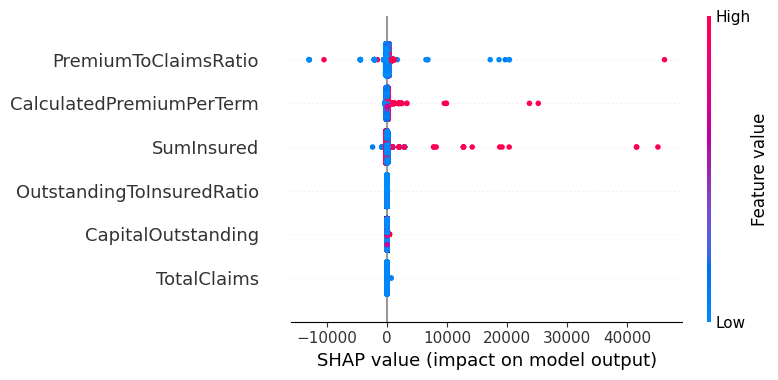

In [22]:
# Step 7: Perform SHAP analysis for feature importance
insurance_modeling.explain_model_shap(X_train)

### Documentation: Predictive Modeling for Insurance Premiums and Claims

#### **1. Problem Definition**
The goal of this analysis was to build predictive models to estimate insurance premiums based on various factors such as claims, capital outstanding, and insured sum. The project involved preparing the data, engineering features, training machine learning models, and interpreting the results to provide insights for the insurance company.

#### **2. Steps Taken**

##### **Step 1: Data Preparation**
- **Missing Value Handling**: 
  - Columns with 100% missing values, such as `NumberOfVehiclesInFleet`, were dropped.
  - For other columns, missing values were imputed. Numerical columns were filled with the median value, while categorical columns were filled with the mode.
  
- **Column Selection**: 
  - The dataset was reduced to relevant columns: `SumInsured`, `CalculatedPremiumPerTerm`, `CapitalOutstanding`, `TotalPremium`, `TotalClaims`.

##### **Step 2: Feature Engineering**
New features were engineered to enhance the predictive power of the models:
- **PremiumToClaimsRatio**: The ratio of total premiums to total claims, capturing the relationship between premium payments and claims.
- **OutstandingToInsuredRatio**: The ratio of capital outstanding to the insured sum, reflecting the financial exposure of the insured entity.

##### **Step 3: Encoding Categorical Data**
- Categorical columns were encoded using one-hot encoding (`get_dummies`), which creates binary columns for each category, helping the models handle categorical variables.

##### **Step 4: Model Training**
Three machine learning models were trained to predict `TotalPremium`:
- **Linear Regression**: A simple linear model that assumes a linear relationship between features and the target.
- **Random Forest Regressor**: An ensemble method that builds multiple decision trees and averages the results for better accuracy and robustness.
- **XGBoost**: A highly efficient and flexible gradient boosting model that sequentially improves predictions.

##### **Step 5: Model Evaluation**
Each model was evaluated using two key metrics:
- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
- **R² Score**: Indicates how well the model explains the variability of the target variable.

##### **Step 6: SHAP Feature Importance**
SHAP (SHapley Additive exPlanations) values were used to explain the contribution of each feature to the model predictions. The SHAP summary plot below shows the impact of each feature on model output:

![SHAP Summary Plot](file-Jjb4Rh8klnRqYFRG30CPkL73)

##### **Step 7: Model Comparison**
The models were compared based on their evaluation metrics:

|               Model           |         MSE          |        R²         |
|-------------------------------|----------------------|-------------------|
| **Linear Regression**          | 4357.165555          | 0.842064          |
| **Random Forest**              | 56.192742            | 0.997963          |
| **XGBoost**                    | 199.034300           | 0.992786          |

#### **3. Interpretation of Results**

- **Random Forest** emerged as the best model with an MSE of 56.19 and an R² of 0.998, indicating almost perfect predictive accuracy. This model captures complex, non-linear relationships between features, making it highly effective for this problem.
  
- **XGBoost** also performed exceptionally well, with an MSE of 199.03 and an R² of 0.993. Its slightly lower performance compared to Random Forest could be due to less interpretability or model complexity.

- **Linear Regression** had the lowest performance, with an MSE of 4357.17 and an R² of 0.842, which is still decent but indicates that a simple linear relationship may not fully capture the complexity of the data.

#### **4. SHAP Feature Importance Analysis**

The SHAP plot shows the contribution of each feature to the model's predictions:
- **PremiumToClaimsRatio**: The ratio of premiums to claims had the largest impact on the model predictions, indicating that the relationship between premiums paid and claims made is critical for understanding future premiums.
- **CalculatedPremiumPerTerm** and **SumInsured**: These features also had significant influence, highlighting that the amount insured and the premium calculated for each term are key drivers of the total premium.
- **CapitalOutstanding** and **OutstandingToInsuredRatio**: While these features had less impact compared to the others, they still played a role in predicting the total premium.

#### **5. Conclusion for the Insurance Company**

Based on the model results, **Random Forest** is recommended for predicting insurance premiums due to its superior performance. The **XGBoost** model also performed well and could be considered if further tuning or deployment requirements favor its use.

The analysis shows that the **Premium to Claims Ratio** is the most influential factor in determining the total premium. This suggests that premiums should be closely tied to the claim history of clients, and insurers may want to refine their policies to more accurately reflect this relationship.

Additionally, features such as **Sum Insured** and **Calculated Premium Per Term** should remain focal points in pricing strategies, as they significantly affect the total premium.

In summary:
- The company can improve its premium predictions using advanced machine learning models like **Random Forest**.
- By focusing on claim histories and ensuring premiums reflect the true risk exposure (through metrics like the **PremiumToClaimsRatio**), insurers can ensure more accurate and profitable pricing strategies.

